In [7]:
import json
import time
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib
from climdist.utils import load_df
import seaborn as sns
import umap
from top2vec import Top2Vec
import colorcet as cc

In [8]:
df = load_df('main')

In [2]:
with open('../data/processed/all_keywords_100522.json', 'r', encoding='utf8') as f:
    entities = json.load(f)

In [3]:
def sentences(until=None):
    with open('../data/processed/RZ_sentences.jsonl', 'r', encoding='utf8') as f:
        if until:
            for ix, line in enumerate(f.readlines()):
                if ix < until:
                    yield json.loads(line)
        else:
            for ix, line in enumerate(f.readlines()):
                yield json.loads(line)

In [4]:
sents = list(sentences())

## Create spans/concordances

In [9]:
def build_spans(sentences, keywords, stretch, window, min_len=1, index_range=None):
    
    if index_range:
        sentences = sentences[index_range[0]:index_range[-1]]
        keywords = keywords[index_range[0]:index_range[-1]]
    
    for entry, line in tqdm(zip(keywords, sentences)):
        
        spans = []
        
        if len(entry['ents']) == 1 and min_len == 1:
            pos = entry['ents'][0][1]
            span_start = pos-window if pos >= window else 0
            span_end = pos+window if (len(line['text']) - pos) > window else len(line['text'])
            spans.append((span_start, span_end))
            
        if len(entry['ents']) >= min_len:
            positions = [ent[1] for ent in entry['ents']]
            distances = [i-j for i, j in zip(positions[1:], positions[:-1])] + ['last']
            #print(positions, distances)
            
            inside = False
            span_len = 0
            for i, pos in enumerate(positions):
                #print(i)
                dist = distances[i] # distance to next position
                if inside == False:
                    #print(entry['ents'][i], 'outside')
                    span_start = positions[i]-window if positions[i] >= window else 0
                    span_len += 1
                    #print('start', span_start)
                    inside = True
                    if dist == 'last':
                        if span_len >= min_len:
                            span_end = positions[i]+window if (len(line['text']) - positions[i]) > window else len(line['text'])
                            #print('end', span_end)
                            spans.append((span_start, span_end))
                    elif dist > stretch:
                        if span_len >= min_len:
                            span_end = positions[i]+window
                            #print('end', span_end)
                            spans.append((span_start, span_end))
                            span_len = 0
                            inside = False 
                        else:
                            inside = False
                    else:
                        pass
                    
                elif inside == True:
                    span_len += 1
                    #print(entry['ents'][i], 'inside')
                    if dist == 'last':
                        if span_len >= min_len:
                            span_end = positions[i]+window if (len(line['text']) - positions[i]) > window else len(line['text'])
                            #print('end', span_end)
                            spans.append((span_start, span_end))
                    elif dist > stretch:
                        if span_len >= min_len:
                            span_end = positions[i]+window if (len(line['text']) - positions[i]) > window else len(line['text'])
                            #print(positions[i], len(line['text'])-positions[i])
                            #print('end', span_end)
                            spans.append((span_start, span_end))
                            inside = False
                        else:
                            span_len = 0
                            inside = False
                    else:
                        pass
                    
        else:
            pass
            
                    
        line['spans'] = spans

                    
    return [line for line in sentences if len(line['spans']) > 0]


def span_texts(entry):
    texts = []
    for span in entry['spans']:
        texts.append(entry['text'][span[0]:span[1]])
    return texts

In [14]:
del spans

In [10]:
spans = build_spans(sents, entities, stretch=100, window=20, min_len=3)
del sents

0it [00:00, ?it/s]

## top2vec

In [24]:
def build_top2vec_corpus(spans):

    corpus = {}
    for entry in spans:
        for i, span in enumerate(span_texts(entry)):
            corpus[str(entry['id'])+'_'+str(i)] = ' '.join(span)
    return corpus


def map_topics_to_main_df(t2v, df, reduction):
    
    t2v.hierarchical_topic_reduction(reduction)
    
    document_ids = t2v.document_ids
    indices = [int(ID.split('_')[0]) for ID in document_ids]
    
    main_topics = [num[0] for x,y,z,num in
                  [t2v.search_topics_by_vector(t2v.document_vectors[i], num_topics=1, reduced=True)
                   for i in range(len(t2v.document_vectors))]   ]
    
    df_small = df.loc[indices]
    df_small['main_topic'] = main_topics
    
    return df_small


def topics_stackplot(topic_df, main_df, relative='local', timerange=range(1802,1889), rolling=True, savepath=None,
                     legend_pos='upper left'):

    matplotlib.rcParams['font.family'] = 'georgia'
    plt.figure(figsize=(15,7))
    
    local_articles = topic_df[(topic_df.year >= timerange[0]) &
                              (topic_df.year < timerange[-1])].groupby('year')['year'].count()
    
    total_articles = main_df[(main_df.year >= timerange[0]) &
                              (main_df.year < timerange[-1])].groupby('year')['year'].count()
    
    topics = sorted(topic_df['main_topic'].unique())
    data = []
    for top in topics:
        topic_counts = topic_df[topic_df['main_topic'] == top].groupby('year')['main_topic'].count().reindex(timerange)
        if relative == 'local':
            data.append((topic_counts/local_articles).fillna(0).rolling(5, min_periods=1).mean())
        elif relative == 'global':
            data.append((topic_counts/total_articles).fillna(0).rolling(5, min_periods=1).mean())
        elif relative == None:
            data.append((topic_counts).fillna(0).rolling(5, min_periods=1).mean())
        else:
            return('Pick "local", "global" or None for parameter "relative"')
            
    #plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.Pastel1.colors)
    #col = sns.color_palette("tab20", len(topics))
    palette = sns.color_palette(cc.glasbey, n_colors=len(topics))
    plt.stackplot(timerange, data, labels=topics, colors=palette)
        
    plt.grid(b=True, which='both')
    plt.xticks(ticks=timerange, labels=[str(i) if i%5==0 else '' for i in timerange], fontsize=14)
    plt.tick_params(axis ='x', rotation = 45)
    if relative:
        plt.ylabel('% de tous les articles', fontsize=20)
    else:
        plt.ylabel("nb d'articles", fontsize=20)
    plt.yticks(fontsize=14)

    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles[::-1], labels[::-1], fontsize=12, loc=legend_pos, ncol=4)
    sns.set_style('ticks')
    
    if savepath:
        plt.savefig(savepath, bbox_inches='tight')
    
    plt.show()
    
    
def get_words_and_headings(topics, t2v, topic_df):
    for num in topics:
        print(list(t2v.topic_words[num]))
        print('\n')
        print(topic_df.loc[topic_df.main_topic == num].heading2.value_counts()[:20])
        print('\n\n\n')

In [11]:
def train_and_plot_top2vec(min_len, **kwargs):
    
    print('Building corpus')
    t2v_corpus = build_top2vec_corpus(build_spans(sents, entities, stretch=100, window=20, min_len=min_len, **kwargs))
    print(f'corpus length: {len(t2v_corpus)}')

    print('Training...')
    t2v = Top2Vec(documents=list(t2v_corpus.values()),
              document_ids=list(t2v_corpus.keys()),
              min_count=20,
              speed='learn',
              workers=8,
              embedding_model_path='../data/models/word2vec_270422/keyedvectors.txt')
    
    num_topics = t2v.get_num_topics()
    print(f'Found {num_topics} topics')
    
    topic_vector_df = pd.DataFrame(index=t2v.document_ids, columns=range(1,301),
                              data=[vec for vec in t2v.document_vectors])
    reducer = umap.UMAP()
    umapped = reducer.fit_transform(topic_vector_df)
    
    main_topics = [num[0] for x,y,z,num in [t2v.search_topics_by_vector(t2v.document_vectors[i], num_topics=1)
                                 for i in range(len(t2v.document_vectors))]]
    umap_df = pd.DataFrame(umapped, columns=['x', 'y'])
    umap_df['topic'] = main_topics
    
    plt.figure(figsize=(12,12))
    sns.scatterplot(data=umap_df, x='x', y='y', s=3, hue='topic',
            palette=sns.color_palette(cc.glasbey, n_colors=len(umap_df.topic.unique())))
    plt.legend(ncol=2)
    plt.grid(False)
    plt.xlabel(None)
    plt.ylabel(None)
    plt.gca().yaxis.set_ticklabels([])
    plt.gca().xaxis.set_ticklabels([])
    plt.show()
    
    #topic_df = map_topics_to_main_df(t2v, df, reduced=False)
    #topics_stackplot(topic_df, df, relative='global', timerange=range(1802,1889))
    #plt.show()
    
    return t2v


def compare_reduced_topics(t2v, reduction, stackplot=False):
    
    print(f'Proceeding with {reduction} topics')
    if reduction == t2v.get_num_topics():
        reduced = False
    else:
        t2v.hierarchical_topic_reduction(reduction)
        reduced = True
    
    topic_vector_df = pd.DataFrame(index=t2v.document_ids, columns=range(1,301),
                          data=[vec for vec in t2v.document_vectors])
    reducer = umap.UMAP()
    umapped = reducer.fit_transform(topic_vector_df)
    
    main_topics = [num[0] for x,y,z,num in [t2v.search_topics_by_vector(t2v.document_vectors[i], num_topics=1, reduced=reduced)
                                 for i in range(len(t2v.document_vectors))]]
    umap_df = pd.DataFrame(umapped, columns=['x', 'y'])
    umap_df['topic'] = main_topics
    
    plt.figure(figsize=(12,12))
    sns.scatterplot(data=umap_df, x='x', y='y', s=3, hue='topic',
            palette=sns.color_palette(cc.glasbey, n_colors=len(umap_df.topic.unique())))
    plt.legend(ncol=2)
    plt.grid(False)
    plt.xlabel(None)
    plt.ylabel(None)
    plt.gca().yaxis.set_ticklabels([])
    plt.gca().xaxis.set_ticklabels([])
    plt.show()
    
    if stackplot:
        topic_df = map_topics_to_main_df(t2v, df, reduced=True)
        topics_stackplot(topic_df, df, relative='global', timerange=range(1802,1889))
        plt.show()

    print(f'\n\n\n\n\nReduction to {reduction} topics\n')
    if reduction < t2v.get_num_topics():
        t2v.hierarchical_topic_reduction(reduction)
        reduced = True
    else:
        reduced = False
    words, scores, nums = t2v.get_topics(reduced=reduced)
    for ix, top in enumerate(words):
        print(f'\n---------- Topic {ix} from {reduction} ----------')
        print(top)

## Main model (2-word spans)

Building corpus


0it [00:00, ?it/s]

2022-05-15 16:33:55,728 - top2vec - INFO - Pre-processing documents for training


corpus length: 24127
Training...


2022-05-15 16:34:07,977 - top2vec - INFO - Creating joint document/word embedding
2022-05-15 16:40:23,869 - top2vec - INFO - Creating lower dimension embedding of documents
2022-05-15 16:40:48,083 - top2vec - INFO - Finding dense areas of documents
2022-05-15 16:40:52,552 - top2vec - INFO - Finding topics


Found 67 topics


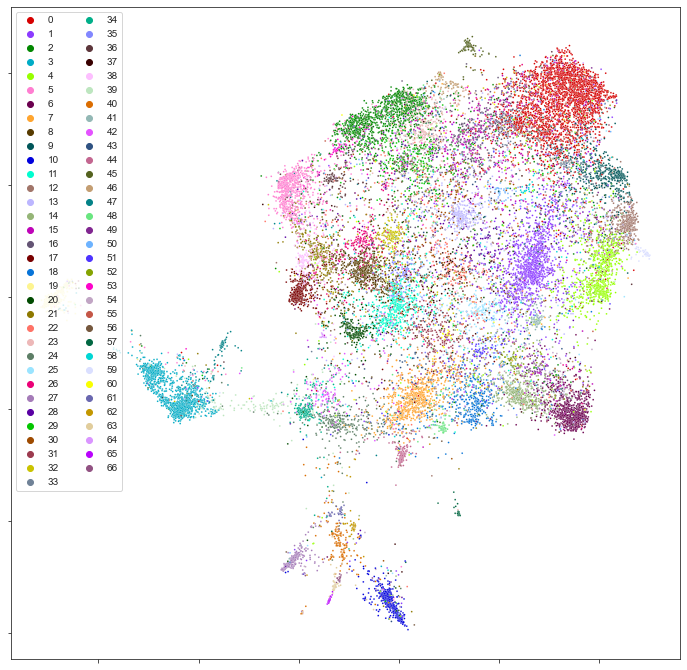

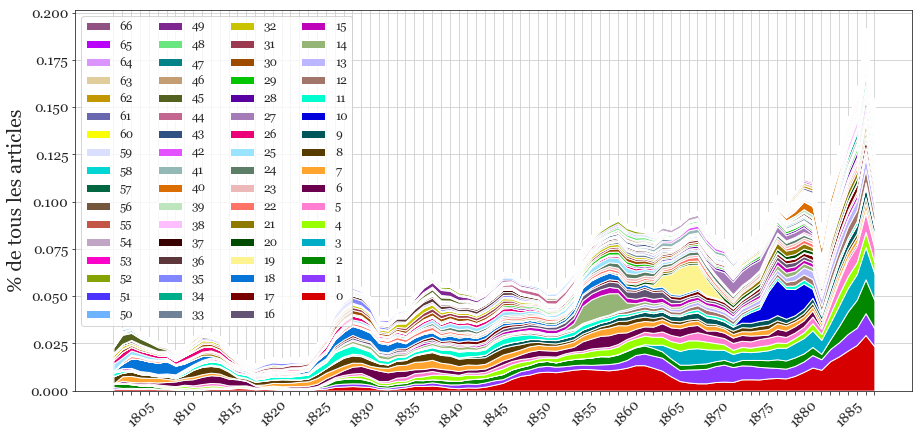

In [60]:
t2v = train_and_plot_top2vec(min_len=2)

In [12]:
t2v = Top2Vec.load('../data/models/top2vec_150522/t2v_model.pkl')

In [13]:
t2v.get_num_topics()

46

Proceeding with 16 topics


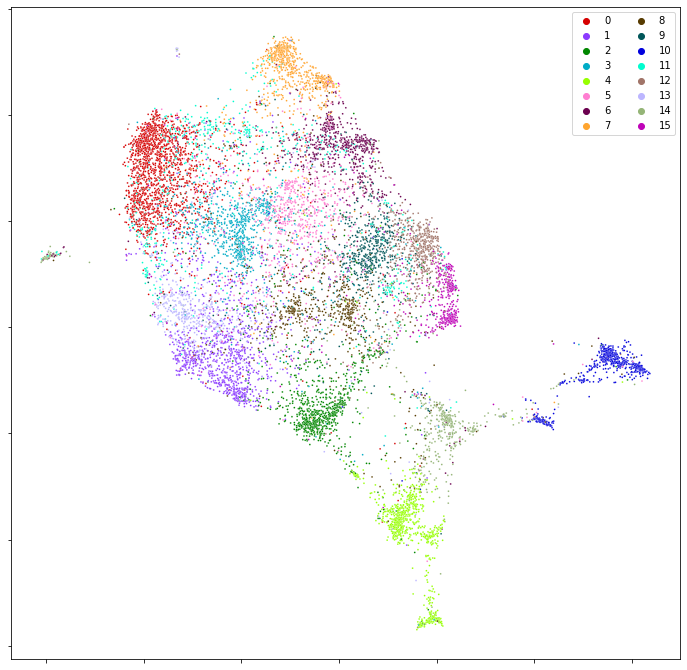






Reduction to 16 topics


---------- Topic 0 from 16 ----------
['stimme' 'herz' 'rief' 'leise' 'liebe' 'augen' 'blick' 'hand' 'geficht'
 'lippen' 'kopf' 'fragte' 'blickte' 'dachte' 'thur' 'seele' 'madchen'
 'arme' 'auge' 'empor' 'gesicht' 'draußen' 'weiß' 'herzen' 'fuhlte' 'wort'
 'gedanken' 'alte' 'kind' 'mutter' 'vater' 'stirn' 'leben' 'ferne'
 'dunkel' 'welt' 'antlitz' 'gott' 'blicke' 'hande' 'mantel' 'fußen'
 'flusterte' 'lacheln' 'wolken' 'lachte' 'klang' 'freund' 'mund' 'schien']

---------- Topic 1 from 16 ----------
['pflanzen' 'klima' 'pflanze' 'bodens' 'boden' 'moglichst' 'warme'
 'anwendung' 'dunger' 'feuchtigkeit' 'oberflache' 'beziehung' 'winter'
 'weise' 'giebt' 'besteht' 'gewohnlich' 'entwickelung' 'bildet' 'liefert'
 'anlage' 'stoffe' 'ausgesetzt' 'erwarmung' 'regel' 'saat' 'erforderlich'
 'verdunstung' 'falle' 'wurzeln' 'tritt' 'vermag' 'geschieht' 'stets'
 'luft' 'futter' 'dungung' 'unkraut' 'gedeihen' 'entsteht' 'acker'
 'besitzen' 'dient' 'warmeleiter' 'thatsac

In [14]:
compare_reduced_topics(t2v, 16)

In [27]:
df_small = map_topics_to_main_df(t2v, df, reduction=16)

In [30]:
for i in range(16):
    print('--------', i, '--------')
    print(df_small.heading2[df_small.main_topic == i].value_counts()[:15])

-------- 0 --------
Vermischtes             37
Riga                    22
Inland                  22
(Fortsetzung.)          18
(Schluß.)               17
Durchgebrannt!          16
Die billige Stadt       14
Berliner Briefe         14
Bilder aus dem Leben    12
Jan Swert               11
Am Vorabend             10
Der junge Straigan      10
Um Liebe und Glück      10
A. Z                     8
Der Kopf der Freya       8
Name: heading2, dtype: int64
-------- 1 --------
Riga                                                  36
Vermischtes                                           34
Inland                                                29
Locales                                               18
Technischer Verein                                    11
Feuilleton                                            10
Mittheilungen                                          7
London                                                 7
Vermischte Nachrichten                                 7
Mannigfaltige

## Early model

In [86]:
early_filter = list(df[(df.year<1860) & (df.readability == 1)].index)
late_filter = list(df[(df.year>=1860) & (df.readability == 1)].index)

In [87]:
len(early_filter) + len(late_filter)

256996

In [89]:
spans_early = build_spans(sents, entities, window=20, stretch=100, min_len=2, index_range = range(len(early_filter)))

0it [00:00, ?it/s]

Building corpus


0it [00:00, ?it/s]

2022-05-15 17:49:29,771 - top2vec - INFO - Pre-processing documents for training


corpus length: 8032
Training...


2022-05-15 17:49:34,231 - top2vec - INFO - Creating joint document/word embedding
2022-05-15 17:51:40,886 - top2vec - INFO - Creating lower dimension embedding of documents
2022-05-15 17:52:01,710 - top2vec - INFO - Finding dense areas of documents
2022-05-15 17:52:02,676 - top2vec - INFO - Finding topics


Found 27 topics


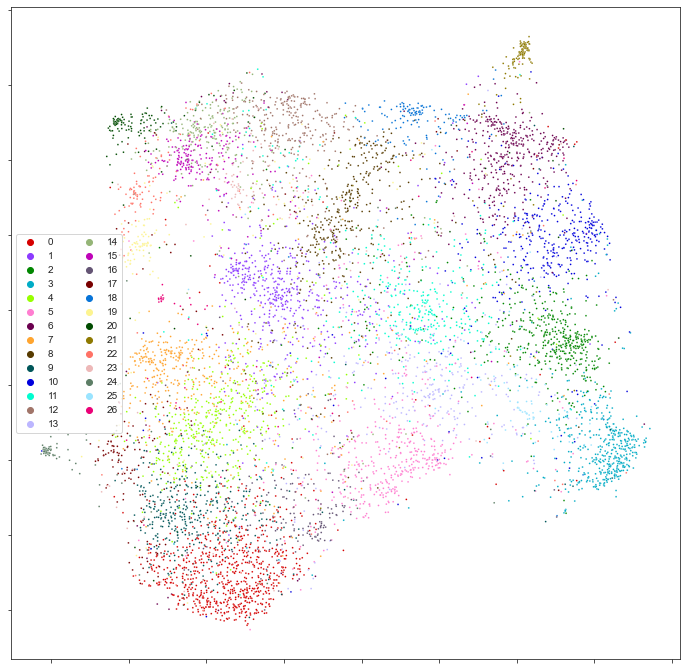

In [111]:
t2v_early = train_and_plot_top2vec(min_len=2, index_range=range(len(early_filter)))

Building corpus


0it [00:00, ?it/s]

2022-05-15 17:52:33,054 - top2vec - INFO - Pre-processing documents for training


corpus length: 5703
Training...


2022-05-15 17:52:39,952 - top2vec - INFO - Creating joint document/word embedding
2022-05-15 17:54:13,979 - top2vec - INFO - Creating lower dimension embedding of documents
2022-05-15 17:54:28,293 - top2vec - INFO - Finding dense areas of documents
2022-05-15 17:54:28,989 - top2vec - INFO - Finding topics


Found 21 topics


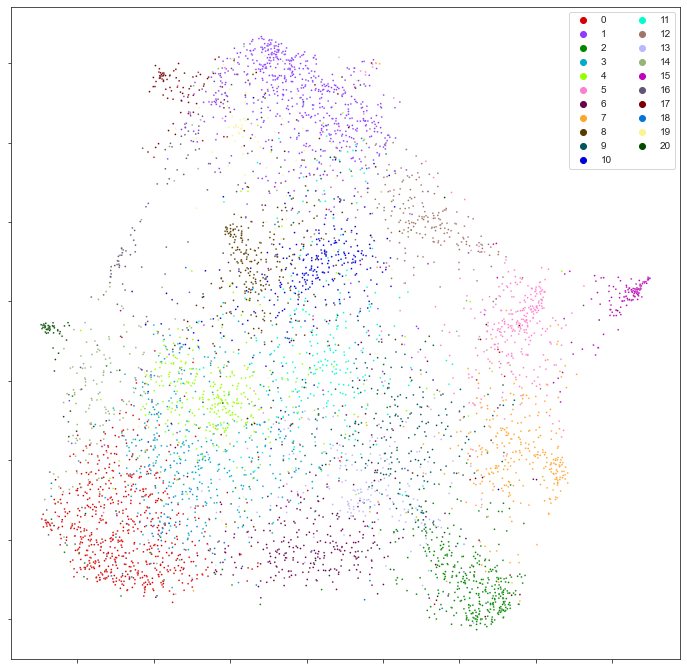

In [112]:
t2v_late = train_and_plot_top2vec(min_len=2, index_range=range(len(late_filter)))

Proceeding with 10 topics


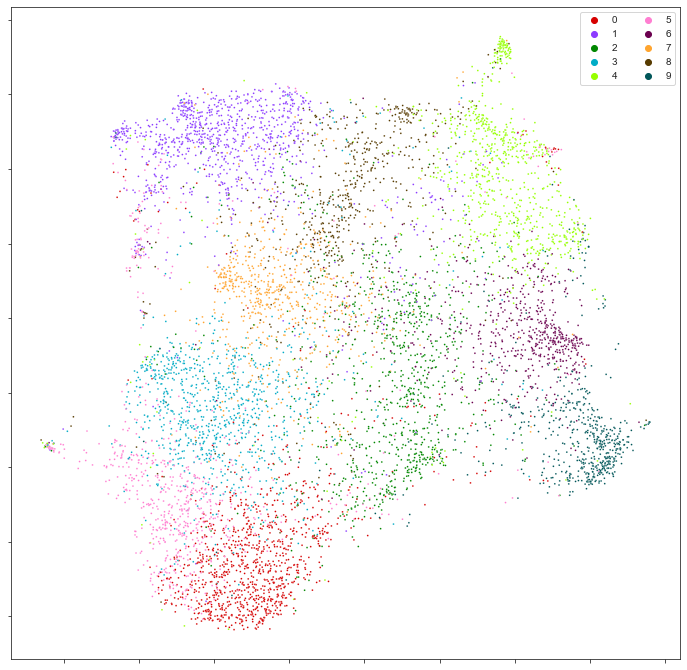






Reduction to 10 topics


---------- Topic 0 from 10 ----------
['rief' 'augen' 'herz' 'stimme' 'mutter' 'fragte' 'lippen' 'seele' 'hand'
 'liebe' 'schrie' 'worte' 'fuhlte' 'wort' 'vater' 'gesicht' 'freunde'
 'lacheln' 'antlitz' 'welt' 'arme' 'blickte' 'lachelnd' 'madchen' 'blicke'
 'dachte' 'kind' 'gefuhl' 'versetzte' 'junge' 'hielt' 'antwortete' 'mund'
 'leise' 'weiß' 'mannes' 'lebens' 'herzen' 'hande' 'druckte' 'selber'
 'gott' 'freund' 'kopf' 'antwort' 'tone' 'brust' 'fußen' 'leben' 'herzens']

---------- Topic 1 from 10 ----------
['schaden' 'hauser' 'dacher' 'beschadigt' 'angerichtet' 'gebaude'
 'zerstort' 'abgedeckt' 'scheunen' 'fortgerissen' 'verwustungen'
 'verwustet' 'wolkenbruch' 'hausern' 'uberschwemmt' 'entwurzelt'
 'menschen' 'heimgesucht' 'vernichtet' 'baume' 'verheerungen' 'trummern'
 'felder' 'ganzlich' 'umgeworfen' 'muhlen' 'brucken' 'uberschwemmte'
 'vieh' 'weggerissen' 'umgegend' 'weggeschwemmt' 'entlud' 'mehreren'
 'anrichtete' 'mehrere' 'hagel' 'erschlagen' 'b

In [117]:
compare_reduced_topics(t2v_early, 10)

Proceeding with 10 topics


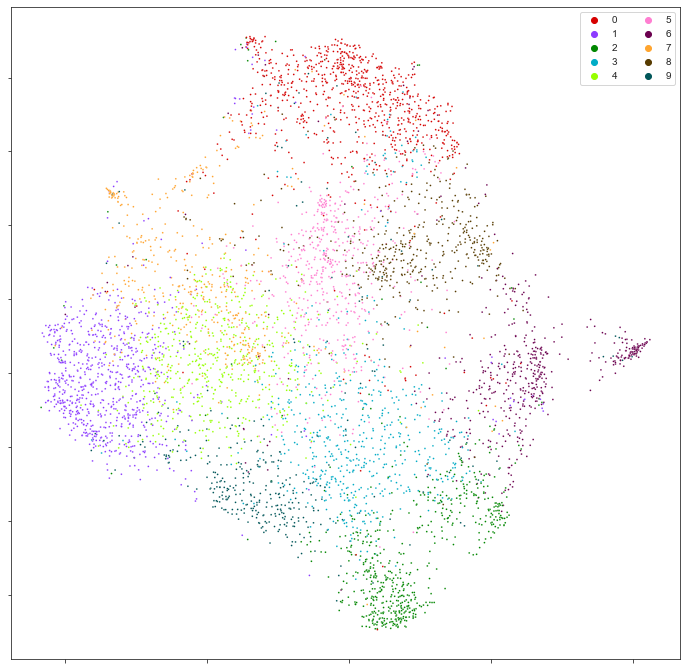






Reduction to 10 topics


---------- Topic 0 from 10 ----------
['hauser' 'zerstort' 'dacher' 'wolkenbruch' 'fortgerissen' 'vernichtet'
 'scheunen' 'verwustet' 'feldern' 'verwustung' 'beschadigt' 'verwustungen'
 'uberschwemmt' 'schaden' 'umgesturzt' 'muhlen' 'zerbrochen' 'brucken'
 'hausern' 'entwurzelt' 'heimgesucht' 'umgegend' 'angerichtet' 'abgedeckt'
 'menschen' 'vieh' 'ortschaften' 'heftiger_sturm' 'ganzlich' 'dorfern'
 'verheert' 'gebaude' 'belauft' 'eingesturzt' 'umgeworfen' 'kirchen'
 'felder' 'orten' 'verheerungen' 'weggerissen' 'wuthete' 'baume'
 'menschenleben' 'entlud' 'weggeschwemmt' 'betroffen' 'einwohner'
 'gebauden' 'dachern' 'anrichtete']

---------- Topic 1 from 10 ----------
['rief' 'hand' 'stimme' 'herz' 'blick' 'lippen' 'wort' 'seele' 'dunkel'
 'blickte' 'blicke' 'liebe' 'augen' 'gesicht' 'antwortete' 'seht' 'horte'
 'worte' 'fragte' 'ewig' 'welt' 'schrie' 'offnete' 'mund' 'thure'
 'vergessen' 'herzen' 'tone' 'mutter' 'fußen' 'draußen' 'stolz' 'gedanken'
 'dach

In [118]:
compare_reduced_topics(t2v_late, 10)